In [185]:
import pandas as pd
import pickle,os, copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
import scipy

import re

from sklearn.cluster import DBSCAN


import margin_flatness as mf
import margin_flatness.postprocessing as mf_post


%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
# add random data to data_getter
# Put a model in a folder. Maybe train for 0 steps. or train on random data. 
# we should now be able to use everything simply.

# Try to test our stuff on more complicated models. VGG or AlexNet. The pretrained ones for now? 

In [227]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "MNIST"
exp = "lr_CE_test_F1"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [228]:
stats_df = mf_post.stats_plotting.get_end_stats(experiment_folder, step=-1)


In [229]:
stats_df.sort_values(by="Acc Test Mean", ascending=False)

,Loss Test Mean,Loss Train Mean,Acc Train Mean,Acc Test Mean,Acc Gap Mean,Trace Mean,Trace Mean Std,learning_rate
1605715095.1954188,0.074436,0.000241,0.999983,0.9816,-0.018383,3.915056,8.917845,0.0215443
1605715095.6922822,0.085897,0.001553,0.999583,0.9807,-0.018883,2.708080,11.584469,0.0464159
1605715094.40962,0.075580,0.000122,1.000000,0.9802,-0.019800,18.516618,55.413696,0.01
1605715096.964226,0.082223,0.000875,0.999850,0.9802,-0.019650,0.653085,2.724202,0.1
1605715098.267734,0.097030,0.002088,0.999367,0.9800,-0.019367,0.527028,3.831264,0.215443
1605715099.5947032,0.105546,0.002681,0.999267,0.9795,-0.019767,0.286670,2.335391,1
1605715098.976371,0.100111,0.003086,0.998933,0.9787,-0.020233,0.572860,4.889204,0.464159
1605715093.8401039,0.084986,0.000283,1.000000,0.9771,-0.022900,35.334635,69.544326,0.00464159
1605715093.351072,0.087886,0.000900,1.000000,0.9752,-0.024800,138.135822,301.450394,0.00215443
1605715092.8236108,0.088735,0.003510,0.999917,0.9738,-0.026117,406.070112,956.701297,0.001


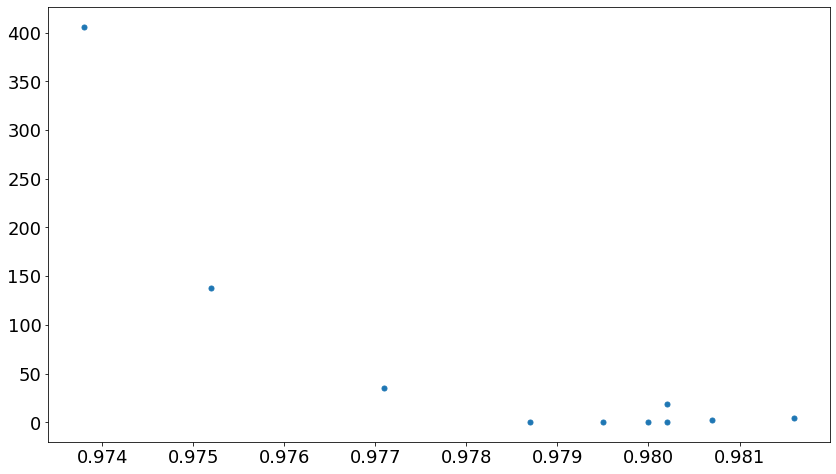

In [230]:
plt.scatter(x=stats_df["Acc Test Mean"], y=stats_df["Trace Mean"])

# Plot Correlations

In [234]:
all_steps = mf.save_load.get_exp_steps(experiment_folder)
all_steps = np.array([list(v.keys()) for v in all_steps.values()]).reshape(-1)
all_steps = sorted(list(set(all_steps)))

# Plot trace vs margins
# X_axis_name = "Output Margins"
X_axis_name = "Jacobian"
Y_axis_name = "Empirical Trace"


plot_name = "C_IC"
X_axis_bounds = None #[0, 1.001]
Y_axis_bounds = None #[0, 200]

should_save = False


filter_seperate = ["batch_train_size", "learning_rate"]
filter_not_seperate = None

pre_filtered_exp_ids = None

use_correct_filter = True
draw_correlation = True



['1605715098.976371']
0.5728595076905784


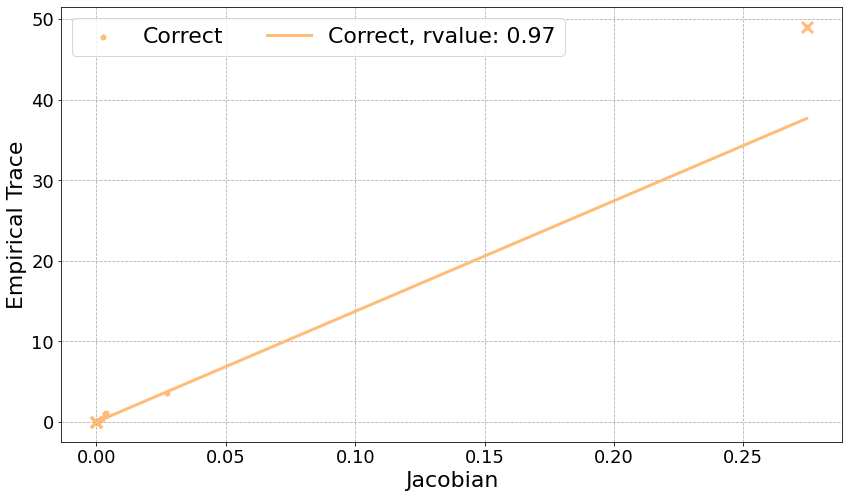

['1605715099.5947032']
0.28666988555064277


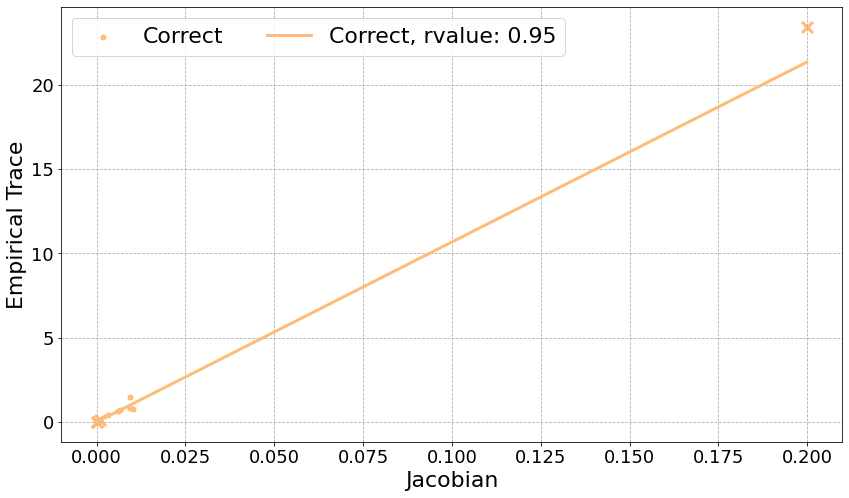

['1605715098.267734']
0.5270282199256839


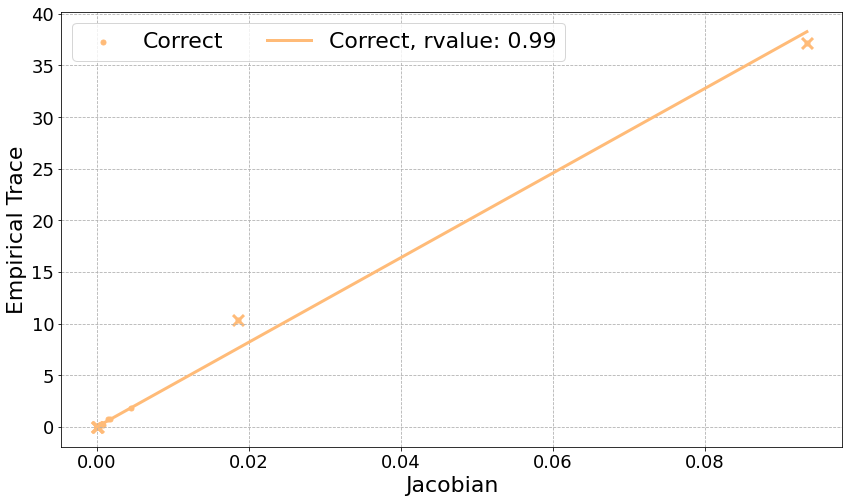

['1605715096.964226']
0.6530845947230687


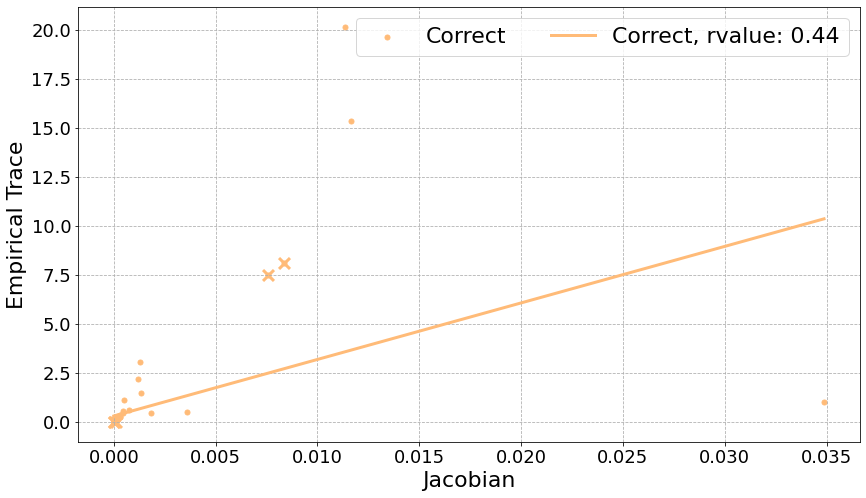

['1605715094.40962']
18.516618203688985


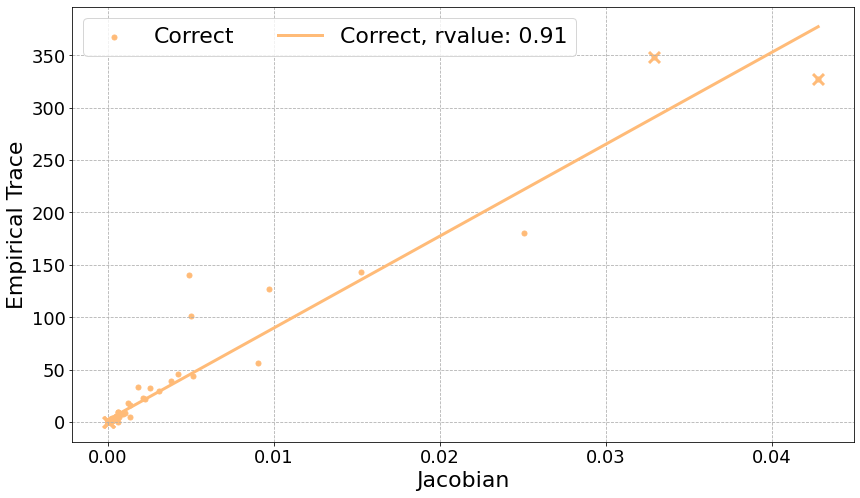

['1605715092.8236108']
406.070111904188


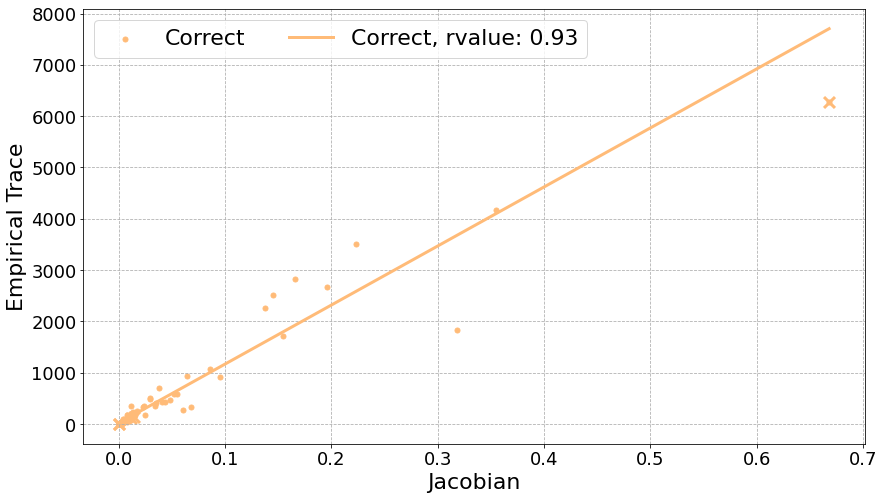

['1605715095.1954188']
3.915056028427378


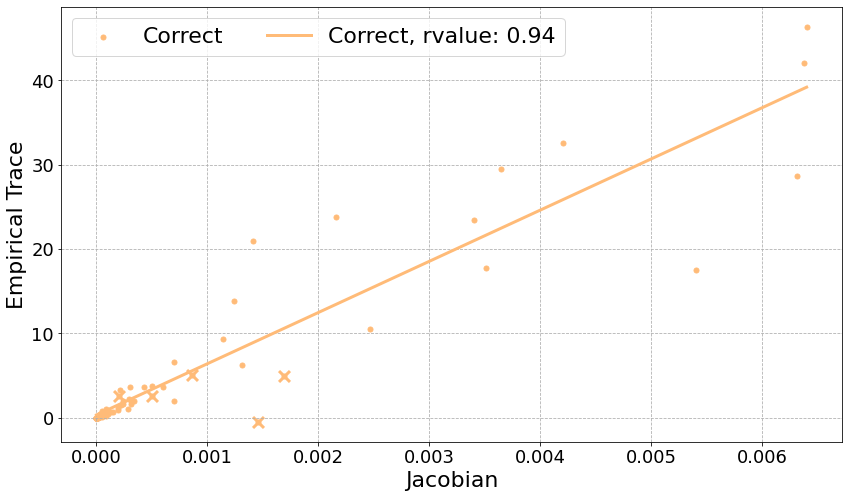

['1605715095.6922822']
2.708079611034371


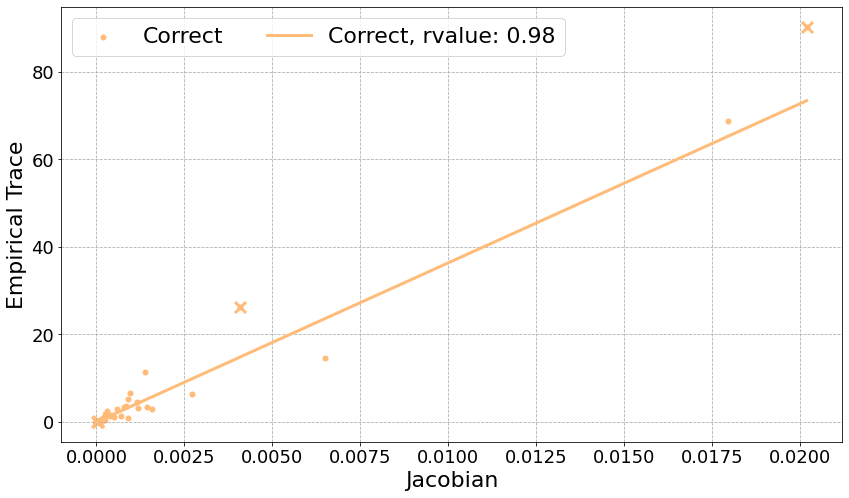

['1605715093.351072']
138.13582171014897


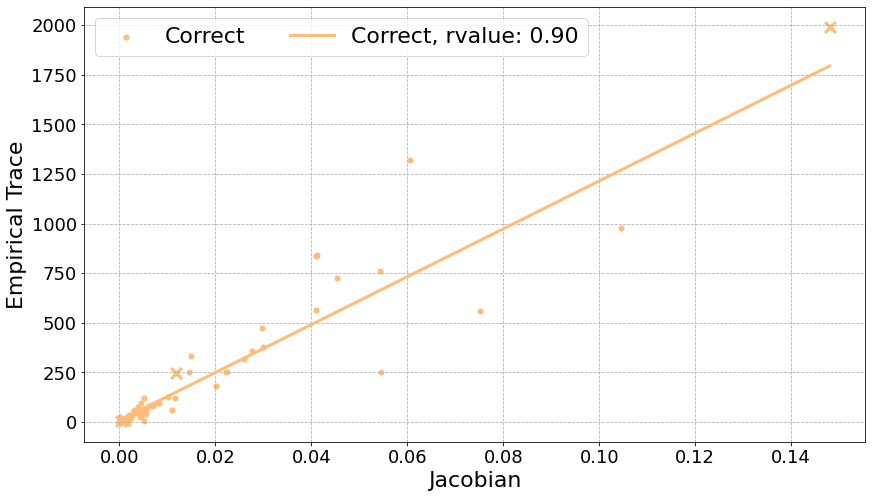

['1605715093.8401039']
35.33463468808351


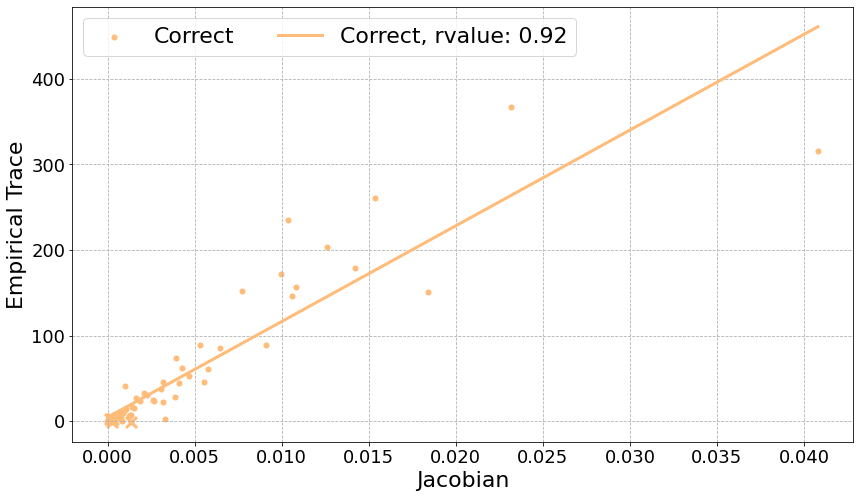

In [235]:
if should_save:
    save_time_path = os.path.join(experiment_folder, "time_corr")
    if not os.path.isdir(save_time_path):
        os.mkdir(save_time_path)
else:
    save_time_path = None

for step in [-1]:
#     acc, _ = load_cached_data(experiment_folder, "acc", step=step)
    
    curr_point_traces, meta = mf.save_load.load_cached_data(experiment_folder, "point_traces", step=step)
    if X_axis_name == "Output Margins":
        corr_candidate_filter = mf_post.postprocess_experiment.get_exp_margins(experiment_folder, softmax_outputs=False, step=step, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)
    
    if X_axis_name == "Jacobian":
        corr_candidate_filter = mf_post.postprocess_experiment.get_exp_inp_out_jacobian(experiment_folder, step=step, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False)
    
    curr_plot_name = "{}_step_{}".format(plot_name, step)
    
    data_func = mf_post.stats_plotting.margin_trace_correct_incorrect_plot(corr_candidate_filter, curr_point_traces, use_correct_filter=use_correct_filter, draw_correlation=draw_correlation)
    
    mf_post.stats_plotting.hp_data_func_plot(experiment_folder, data_func, X_axis_name, Y_axis_name, 
                      curr_plot_name, filter_seperate, filter_not_seperate,
                 save_time_path, X_axis_bounds, Y_axis_bounds, 
                    pre_filtered_exp_ids)

 


In [151]:
# root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
# data_name = "MNIST"
# exp = "Keskar_F1"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)


# X_data_filter_f = lambda step: get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

X_data_filter_f = lambda step: get_exp_margins(experiment_folder, get_upperbound=True, softmax_outputs=True, step=step, seed=0, device=None, num_datapoints=100, on_test_set=False, should_cache=False) # get_exp_linear_loss_trace(experiment_folder, step=step, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)

Y_data_f = lambda step:  load_cached_data(experiment_folder, "point_traces", step=step)[0]
use_correct_filter = True
c = get_corr_array(experiment_folder, X_data_filter_f, Y_data_f, use_correct_filter)


0
Files already downloaded and verified
Files already downloaded and verified
0.007775068283081055
0.0053670406341552734
0.004993915557861328
-11415364.423753237
1
Files already downloaded and verified
Files already downloaded and verified
0.006078958511352539
0.005401134490966797
0.005295753479003906
-1422420.8682907124
1001
Files already downloaded and verified
Files already downloaded and verified
0.0066449642181396484
0.006666898727416992
0.0058100223541259766
-4276.959316511439
2001
Files already downloaded and verified
Files already downloaded and verified
0.006390094757080078
0.006201982498168945
0.006473064422607422
-895.4957707184025
3001
Files already downloaded and verified
Files already downloaded and verified
0.005825042724609375
0.005322933197021484
0.004847049713134766
113.71981656160801
4001
Files already downloaded and verified
Files already downloaded and verified
0.005561113357543945
0.005582094192504883
0.005338191986083984
-231.58002542439414
5001
Files already dow

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.006345987319946289
0.006281852722167969
0.006587028503417969
6819.68039839413
35001
Files already downloaded and verified
Files already downloaded and verified
0.00621795654296875
0.005480289459228516
0.005060911178588867
6973.292069336138
36001
Files already downloaded and verified
Files already downloaded and verified
0.006343841552734375
0.005423784255981445
0.005165815353393555
6567.187020832616
37001
Files already downloaded and verified
Files already downloaded and verified
0.0055768489837646484
0.005276203155517578
0.005255937576293945
5395.665370700272
38001
Files already downloaded and verified
Files already downloaded and verified
0.005836963653564453
0.00545191764831543
0.00550079345703125
7545.026453447821
39001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.0059778690338134766
0.0053501129150390625
0.005009174346923828
7847.011097193467
40001
Files already downloaded and verified
Files already downloaded and verified
0.005805015563964844
0.005658864974975586
0.0052089691162109375
8585.72644587561
41001
Files already downloaded and verified
Files already downloaded and verified
0.005549192428588867
0.0052280426025390625
0.005177974700927734
9816.4114276096
42001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.006154775619506836
0.006459951400756836
0.005519866943359375
8052.373098327558
43001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.005566120147705078
0.005244016647338867
0.004961967468261719
6601.536415384855
44001
Files already downloaded and verified
Files already downloaded and verified
0.005669355392456055
0.00516200065612793
0.0050928592681884766
3990.7573044233627
45001
Files already downloaded and verified
Files already downloaded and verified
0.00568389892578125
0.00626826286315918
0.004968166351318359
11555.92778558974
46001
Files already downloaded and verified
Files already downloaded and verified
0.005666017532348633
0.00519871711730957
0.0052187442779541016
9148.523637873986
47001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.006172895431518555
0.005444049835205078
0.004942893981933594
6642.394063724272
48001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.005568027496337891
0.005622148513793945
0.005536079406738281
14456.385045624216
49001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.005755901336669922
0.0052509307861328125
0.005002021789550781
5158.536396293251
50001


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.0054547786712646484
0.005730152130126953
0.0049610137939453125
8078.7041606656285
50002


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Files already downloaded and verified
Files already downloaded and verified
0.005645036697387695
0.005626678466796875
0.00490880012512207
8078.7041606656285


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


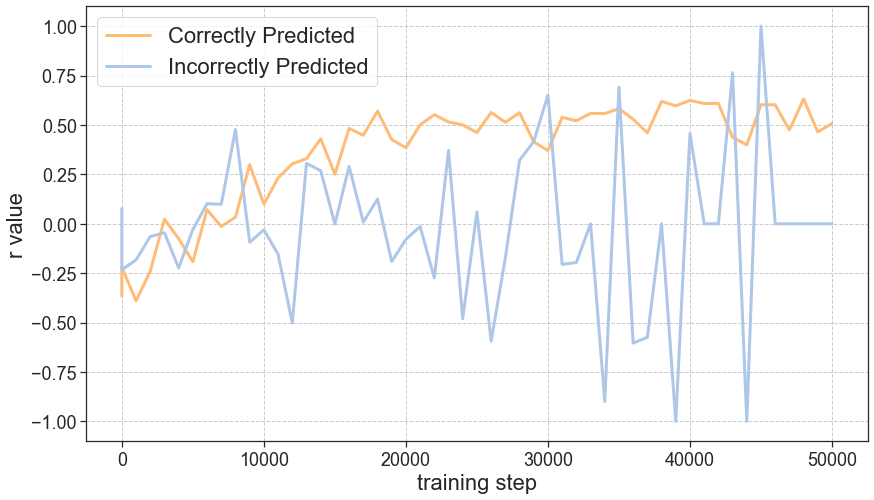

In [152]:
for exp_id in c:
    if exp_id != "1605478459.1644921":
        continue
        
    a = c[exp_id]["0"]

    plots = []
    plots_names = []
    X_axis_name = "training step"
    Y_axis_name = "r value"

    save_location = None # os.path.join(experiment_folder, "time_r_margins_{}".format(stats_df.loc[exp_id]["batch_train_size"]))


    plots.append(plt.plot(list(a["correct_r_value"].keys()), list(a["correct_r_value"].values()), label="Correctly Predicted", color=COLORS[CORRECT_COLOR_IDX]))
    plots.append(plt.plot(list(a["incorrect_r_value"].keys()), list(a["incorrect_r_value"].values()), label="Incorrectly Predicted",  color=COLORS[INCORRECT_COLOR_IDX]))
#     plots_names = ["Correctly Predicted", "Incorrectly Predicted"] 

    
    costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)



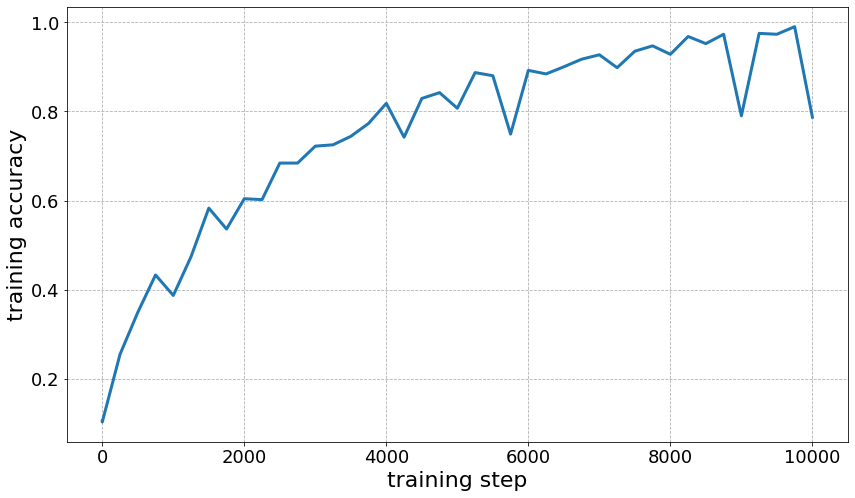

In [158]:
plots = []
plots_names = []
X_axis_name = "training step"
Y_axis_name = "training accuracy"

save_location = os.path.join(experiment_folder, "time_acc")


plots.append(plt.plot(list(a["acc"].keys()), list(a["acc"].values())))

costum_plot(plots, plots_names, X_axis_name, Y_axis_name, X_axis_bounds=None, Y_axis_bounds=None, save_location=save_location)



In [185]:
h_arr = []
m_arr = []
for step in np.linspace(0, 10000, 21):
    print(step)
    curr_point_traces, meta = load_cached_data(experiment_folder, "point_traces", step=int(step)+1)
    h_arr.append(curr_point_traces)
#         linear_loss_trace_filters = get_exp_linear_loss_trace(experiment_folder, step=step+1, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
    linear_loss_trace_filters = get_exp_margins(experiment_folder, softmax_outputs=False, step=int(step) + 1, seed=0, device=None, num_datapoints=1000, on_test_set=False, should_cache=False)
#     h_arr.append(curr_point_traces)
    m_arr.append(linear_loss_trace_filters)
    




0.0
0.035897016525268555
0.041513919830322266
500.0
0.03803586959838867
0.03834700584411621
1000.0
0.03677177429199219
0.03812575340270996
1500.0
0.04125714302062988
0.04334616661071777
2000.0
0.03639698028564453
0.041529178619384766
2500.0
0.04678010940551758
0.040138959884643555
3000.0
0.04562497138977051
0.04002571105957031
3500.0
0.04656505584716797
0.04803204536437988
4000.0
0.04390096664428711
0.03978300094604492
4500.0
0.04471302032470703
0.03677105903625488
5000.0
0.03907203674316406
0.03734922409057617
5500.0
0.044157981872558594
0.04265189170837402
6000.0
0.044261932373046875
0.03972220420837402
6500.0
0.04278683662414551
0.040013790130615234
7000.0
0.04221701622009277
0.04300284385681152
7500.0
0.045823097229003906
0.041023969650268555
8000.0
0.043543100357055664
0.041185855865478516
8500.0
0.045545101165771484
0.03993391990661621
9000.0
0.043974876403808594
0.04049992561340332
9500.0
0.0421602725982666
0.038110971450805664
10000.0
0.04344964027404785
0.0391387939453125


In [192]:
h_res = [[], []]
for t in range(len(m_arr)):
    for i, exp_id in enumerate(h_arr[t]):
        h = h_arr[t][exp_id]['0']
#         h_res[i].append(np.mean(h))
        h_res[i].append(scipy.stats.moment(h, moment=3))

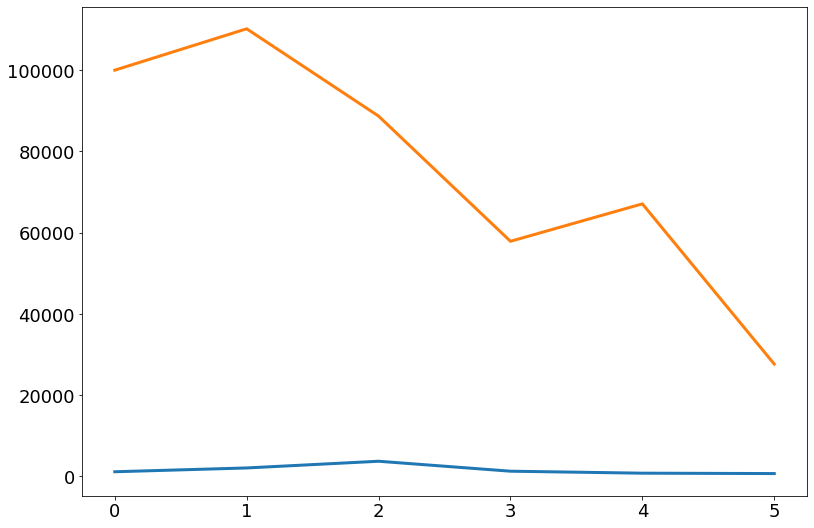

In [198]:
plt.plot(h_res[0][15:])
plt.plot(h_res[1][15:])


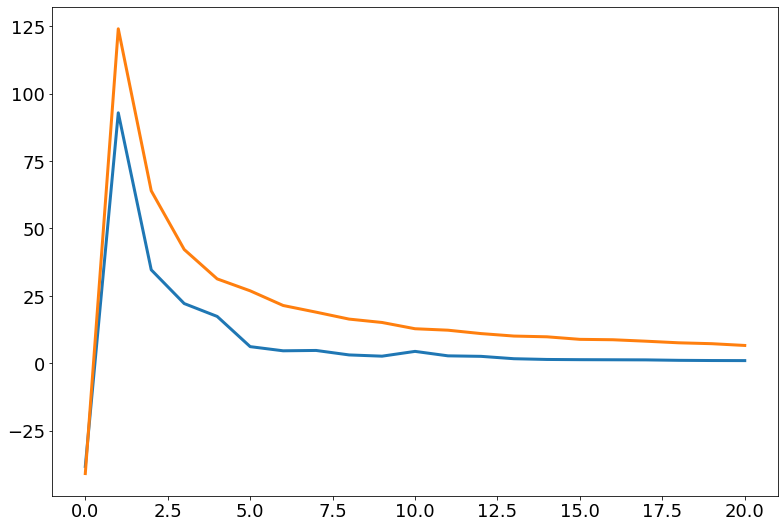

In [191]:
plt.plot(h_res[0])
plt.plot(h_res[1])


In [194]:
res = [[], []]
for t in range(len(m_arr)):
    for i, exp_id in enumerate(m_arr[t]):
        m, f = m_arr[t][exp_id]['0']
#         res[i].append(np.mean(m[f]))
        res[i].append(scipy.stats.moment(m[f], moment=3))

In [182]:
res

[[], []]

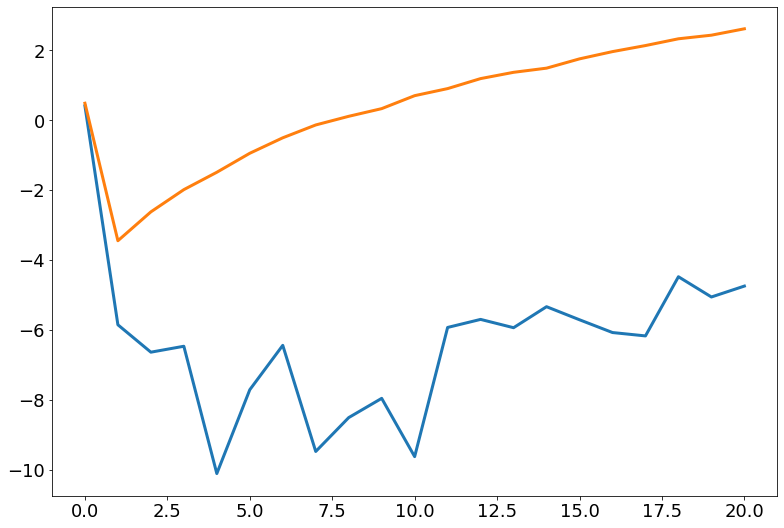

In [195]:
plt.plot(res[0])
plt.plot(res[1])


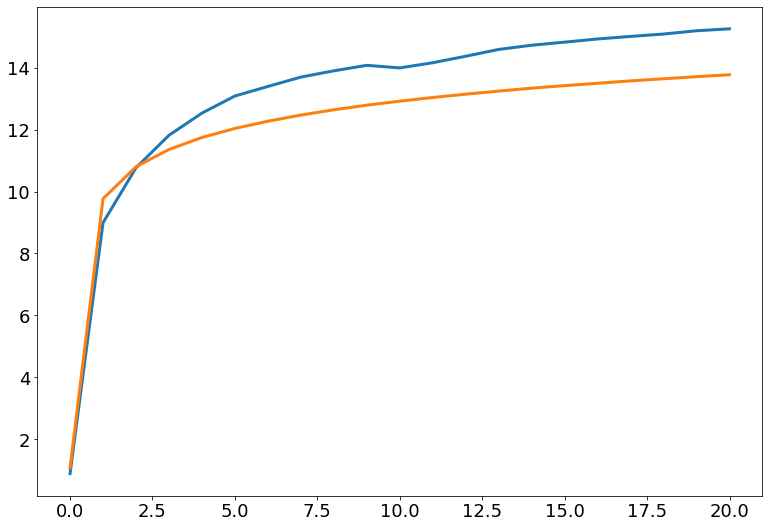

In [170]:
plt.plot(res[0])
plt.plot(res[1])


In [256]:
def get_model_num_params(model):
    num_params = 0
    for name1, param1 in model.named_parameters():
        num_params += param1.numel()
    return num_params

# m = mf_nets.Nets.BatchNormSimpleNet(28* 28* 3, 10)

m = mf_nets.Nets.KeskarC3(28, 28, 3, 10)
get_model_num_params(m)

3647232

In [238]:
import margin_flatness.nets as mf_nets 